博客论文：https://distill.pub/2021/gnn-intro/

本文做什么？

1. 什么数据可以表示成图？
2. 图和别的数据的区别？Why use GNN?
3. GNN 的构建模块长什么样？
4. playground 一定要玩一玩，作者很用心

# 前言

# 什么是图

实体（顶点 node）之间的关系（边 edge）。A graph represents the relations (edges) between a colelction of entities(nodes). 
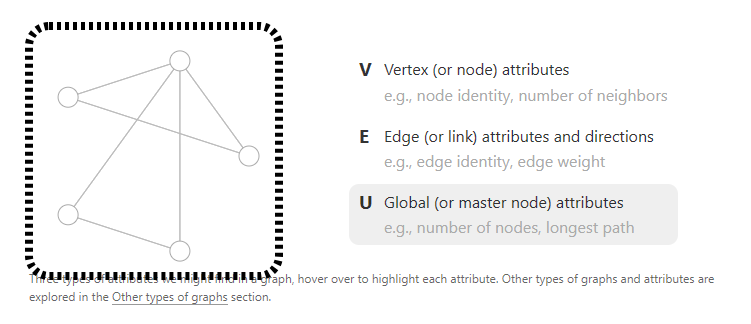

1. V 顶点
2. E 边
3. U 全局信息，整个图

attributes in V E U 重要吗？

！关心图的整个架构

！更关心 每个顶点、每条边、和 整个图表示的信息

## attribute 如何表示呢
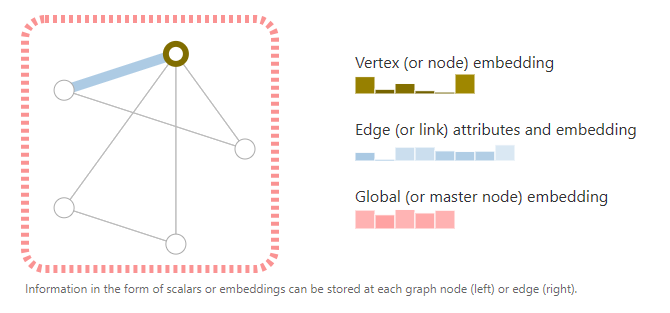
embedding 表示 V E U 的 attributes

## GNN 重点是什么？图表示学习
这些向量是否能通过学习数据，从而表示我们想要的信息？

图的分类：无向图（微信朋友） + 有向图（B站up主和粉丝）

## 数据如何表示成图？
### 图片如何表示成图？

 244 * 244 * 3通道，3维度的tensor
 
1. 把图片看作一张图，一个像素是一个点；一个像素跟我是连接关系的话，像素之间连一条边。
2. 把图片上的像素 映射到 图上的每一个点

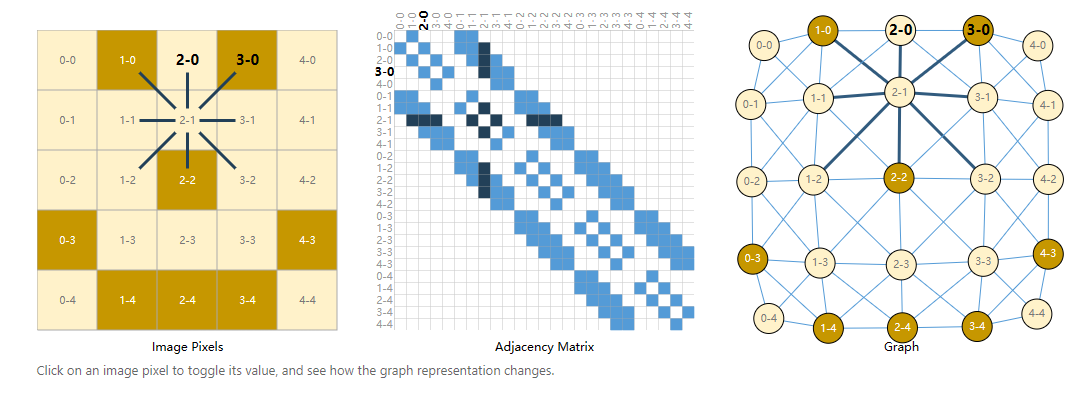

边信息：2-2的八邻居

### 文本如和表示成边？
文本的顺序：图的有向路
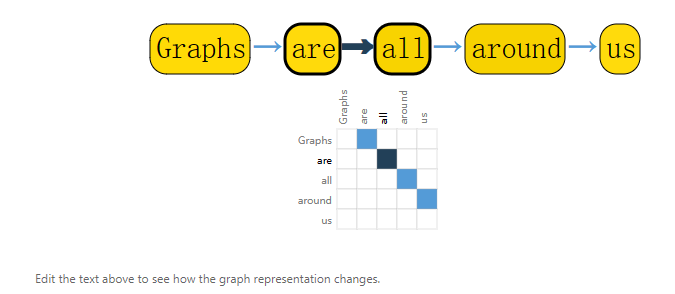

### 除了图片、文本，还有什么数据可以表示成图？

香料分子图、咖啡因的分子图、社交网络图、引用图(directed)
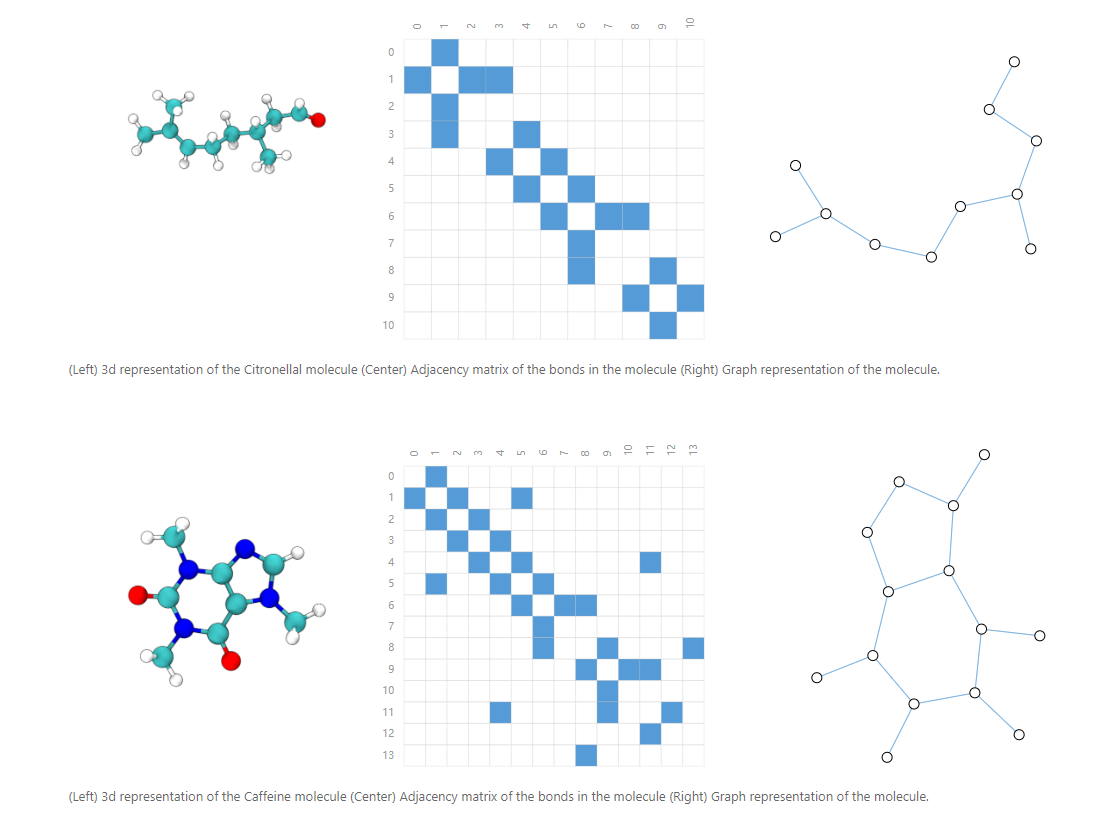
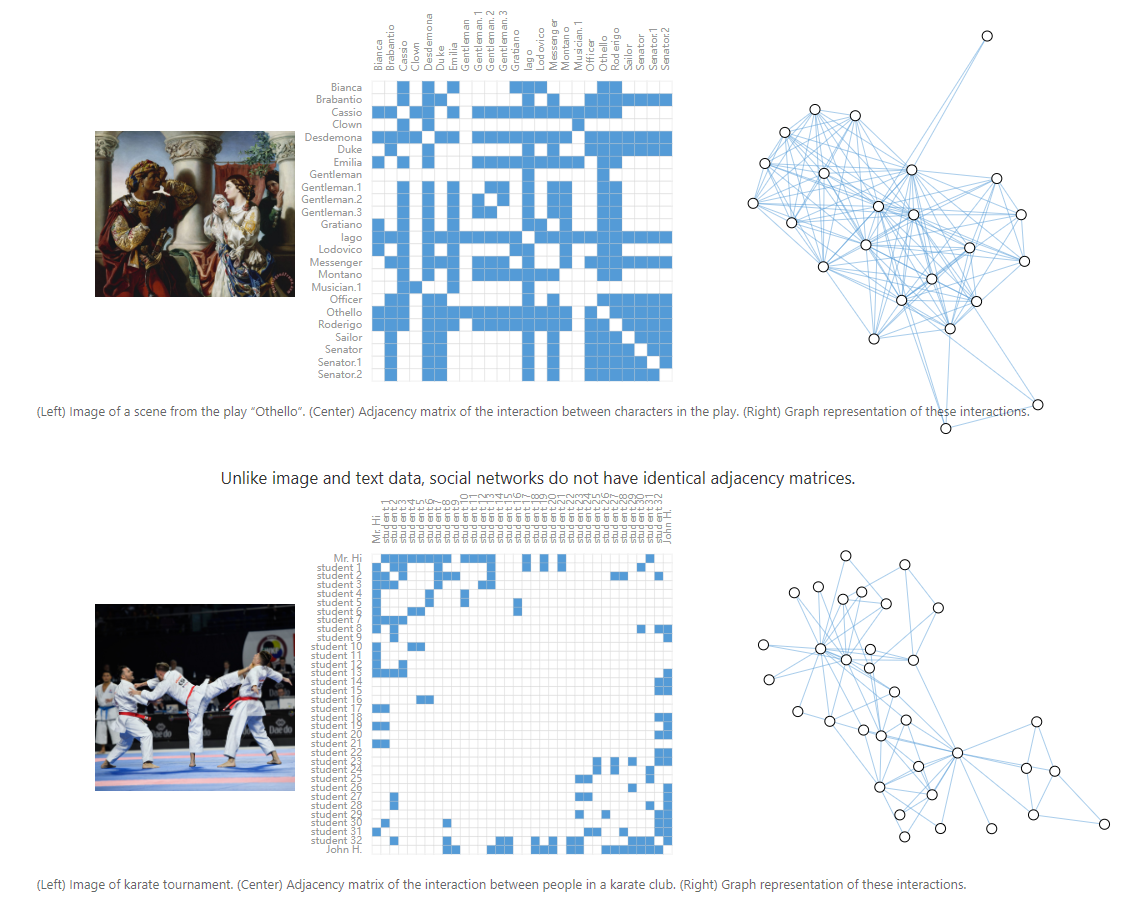

## 解决的问题
三方面：graph-level U, node-level V, edge-level E

### graph-level task 
图分类：图中是否有环
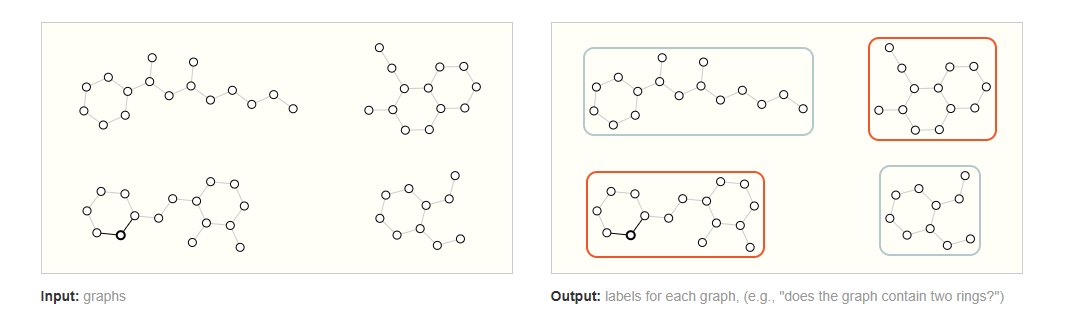

### node-level task

顶点分类：跟老师A 还是 B 蓝还是红

选举预测
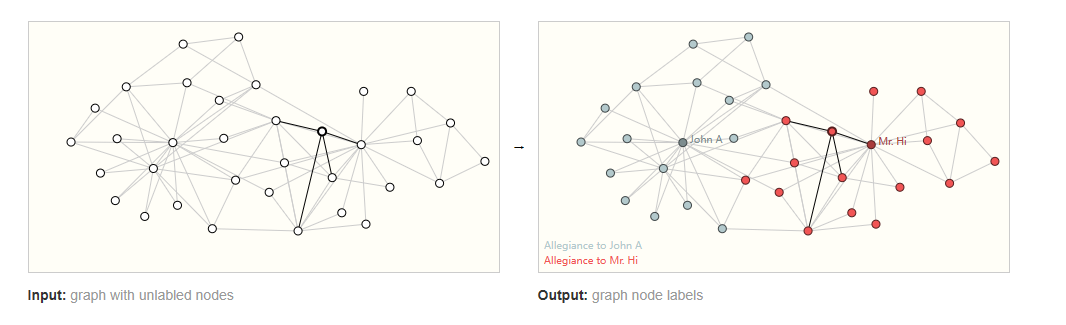

### edge-level task

图中顶点和边的关系

watching fighting
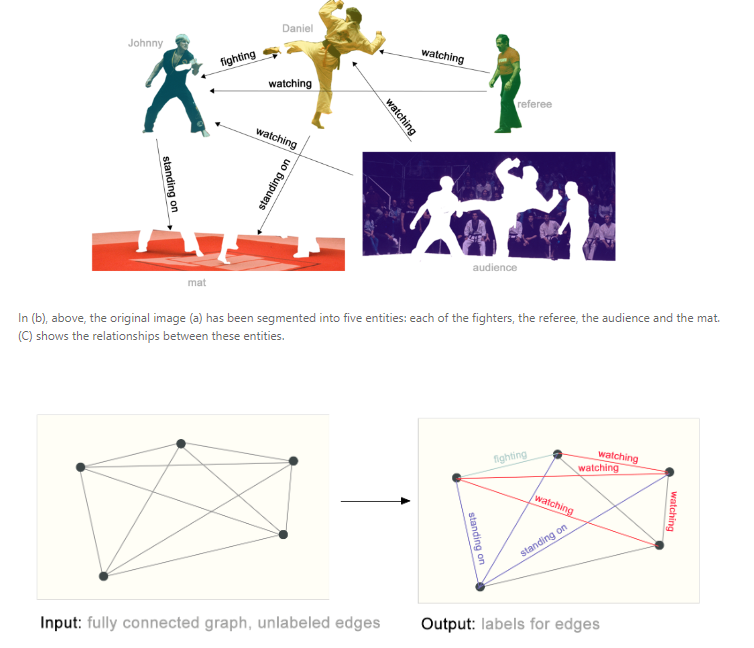

## 挑战 - 如何使 图 和 神经网络 兼容？
图有几类信息需要表示？

nodes V, edges E, global-context U and connectivity

V E U 可以用 vector 表示，问题是 connectivity 如何表示？by adjacent matrix? 

n * n 的 0-1 元素矩阵 表示 connectivity 可以吗？

矩阵很大，i.e., wikipedia数据集，12M nodes，矩阵会有12M行、12M列，无法存储。
边通常是稀疏的，存储 sparse matrix ✔；但稀疏矩阵在GPU上的高效运算，难❌
邻接矩阵的 行、列顺序交换，不会影响图

左图和右图是 permutation 的关系，放进 NN 应得到相同的结果。
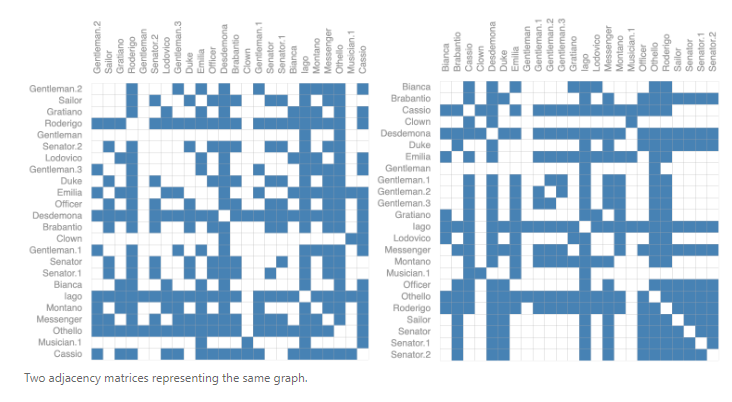


异构图的特别详细的例子

4个顶点，4条边，24种不同的排序，24个邻接矩阵
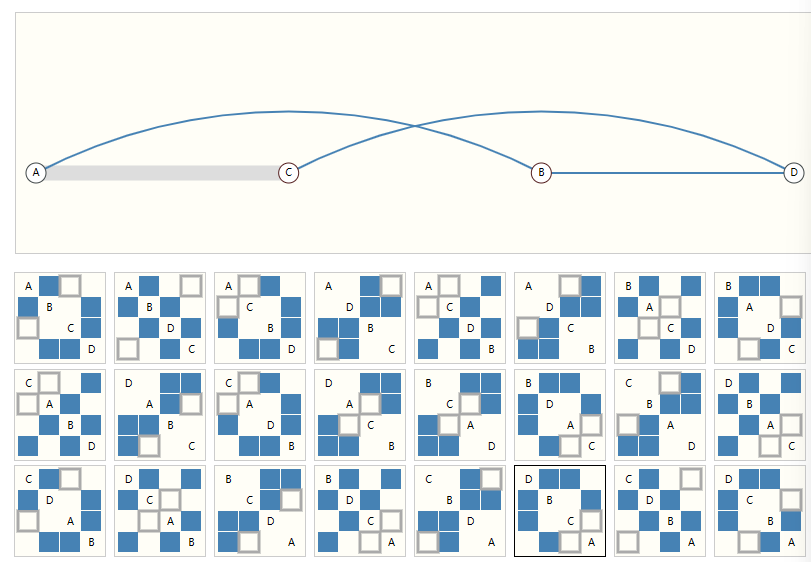

如何高效存储、顺序无关的图呢？

8个顶点、7条边。

图中点和边的属性、全局信息用标量示例，也可以用向量表示。
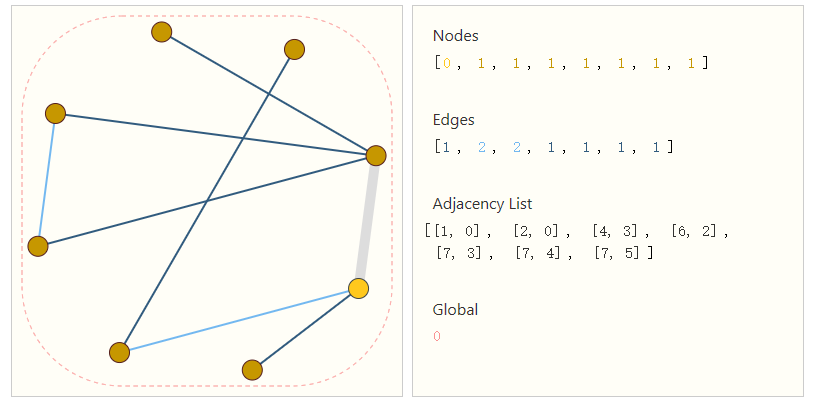
Nodes, Edges, Adjacency List, Global 的存储方式怎么样？

存储高效，顺序无关

# 图神经网络
输入一个高效存储、顺序无关的 Nodes, Edges, Adjacency List, Global 信息，如何用 NN 处理呢？---- Graph Neural Networks

## GNN定义：

A GNN is  an optimizable transformation on all attributes of the graph (nodes, edges, global-contex ) that preserves graph symmetries (permuation invariance).

图上属性的 可以优化的变化，且保持图的对称信息。GNN 对 attributes 向量进行变化，不改变原图的连接性。

## The simplest GNN
Un 全局向量, Vn 顶点向量, En 边向量 分别构造一个MLP, MLP的输入输出的大小一致。

3个MLP f_Un, f_Vn, f_En 组成一个 GNN 的层。

MLP f_Un, f_Vn, f_En  分别对输入的 Un 全局向量, Vn 顶点向量, En 边向量 计算，得到更新 Un+1 全局向量, Vn+1 顶点向量, En+1 边向量 。
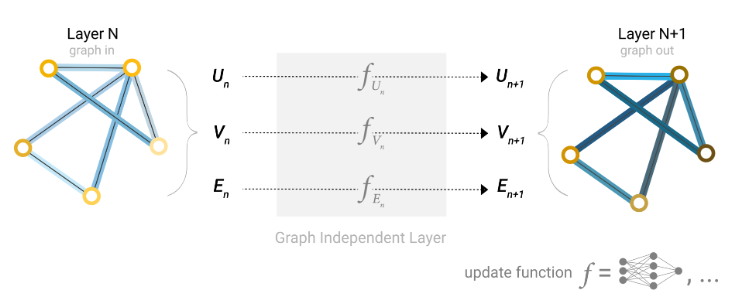
Permutation invariance

MLP 是对每一个向量独自作用，MLP 不会考虑所有的连接信息，所以不管排序如何变化，都不会改变 MLP 的输出结果。

可以对simplest GNN 层叠加，构造一个比较深的 GNN

### 最后一层的输出，怎么得到预测值？

simplest: nodes prediction 顶点预测

分类预测: i.e., 空手道俱乐部喜欢 A 老师还是 B 老师

和 NN 类似，node embeddings 向量 接入 输出维度为 2 or n 的全连接层 + 一个 softmax，得到分类结果；输出维度为 1，得到回归结果。

最后一层的顶点进入 图中的 C_V_{i,n} classification 全连接网络，得到顶点的分类。

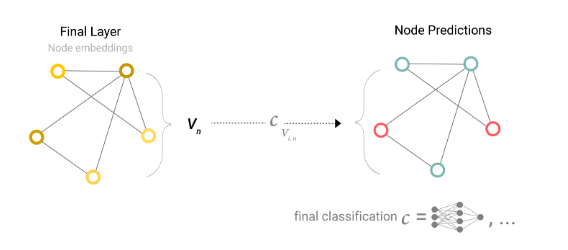
Note: 所有顶点共享一个全连接层 C_V_{i,n} 的参数。

GNN 之前的层，不论图有多大，一层里面只有 3 个MLP

* 所有顶点共享一个 MLP
* 所有边共享一个 MLP
* 所有的全局 U（全局只有一个）不用共享。

信息是隔离的，没有联系在一起

## pooling 汇聚 （似 CNN 的 pooling）
与缺失点连接的边的向量 4个 + 全局向量 1 个 == 代表这个缺失点的向量，再做一个全连接层的预测输出。

假设：所有顶点、边、全局向量的维度一致；不一致，需要做投影。
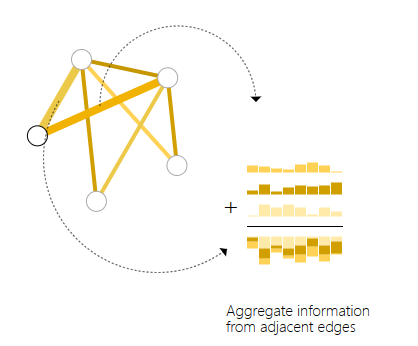

别的缺失点，连接关系不一样，最后需要相加的向量也不一样。

1. 缺失点预测的示意图

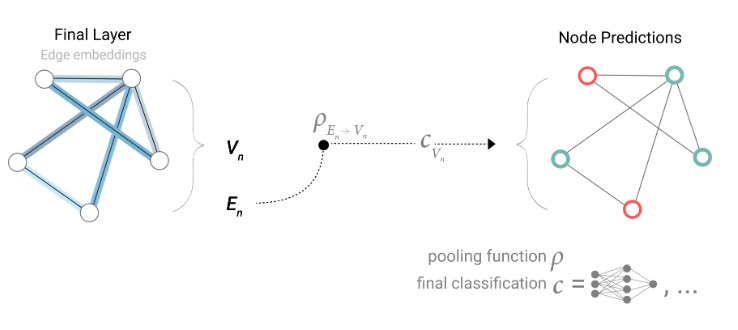
V_n 是只有边、没有顶点的向量

E_n 是边的向量

Rho_{E_n --> V_n} 通过 pooling 汇聚从 边 +全局 到 顶点的信息， 进入顶点共享的分类层 C_V_n 之前，每个顶点都有自己的向量 embedding

2. 只有 node embeddings 没有 边的向量，怎么办？

Rho_{V_n --> E_n} 把 node embeddings 汇聚到 vertex 边上。

一条边，连接两个顶点，2个顶点向量相加 （+ 全局向量）== 得到 边的向量，然后进入边共享的一个 MLP 预测分类网络，得到边的预测输出。
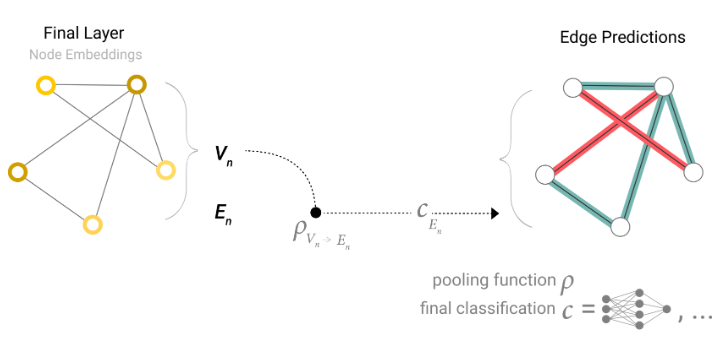

3. 没有全局向量 U, 有 node embeddings, 对整个图做预测？
把所有的 node embeddings 加起来，得到一个全局的向量，进入全局的MLP，得到一个全局的预测输出。
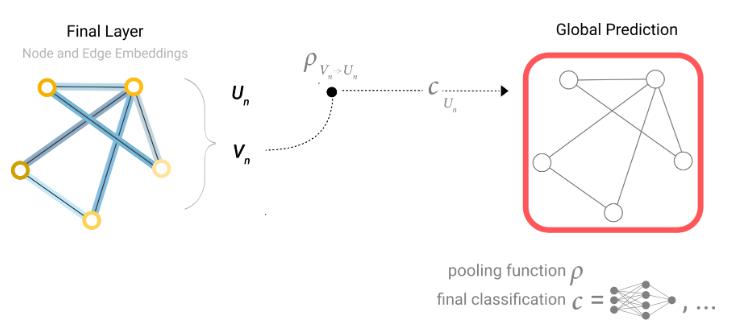
总结：不论缺少哪一类 V E U attributes，pooling 汇聚得到缺失值 embeddings，进入MLP，得到预测值。

## 最简单的 GNN 示意图
input graph 经过 GNN blocks （每一个 block 里面有 3个 MLP对 V顶点 E边 U全局 attributes 更新）得到 一个同结构的 transformed graph, 但 V E U 属性值已被更新。

(if 某类 embeddings 缺失，通过其它 embeddings pooling 汇聚而来)

最后根据 V E U 某类属性做预测，接一个 MLP classification layer 输出预测信息。
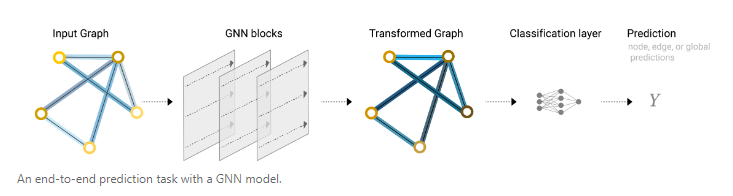


## 问题
GNN blocks 没有使用图结构信息：使用 MLP 更新属性值时，没有看到 V 顶点 E 边 的交互信息，只是 V 进 MLP_V, E 进 MLP_E, U 进 MLP_U，忽略了点边之间的连接信息。

overlook information: 一个顶点与哪些边相连，一个顶点与哪些顶点相连；一条边与哪些顶点相连，一条边与哪些边相连

GNN blocks 没有合理的将整个图的信息更新到属性值里，最后的结果不能 leverage 图的信息。

## Passing messages
相邻节点将被池化、更新和存储的相邻嵌入。其实就是一个node聚合与它相关的nodes，也就是node = node + neighbor nodes，这个操作本质和CNN很像
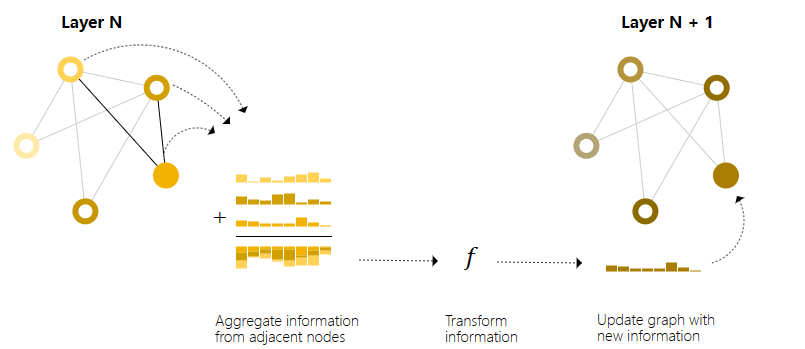

通过池化距离为一度的相邻节点来更新图的节点表示。上述操作可以表示为1-近邻
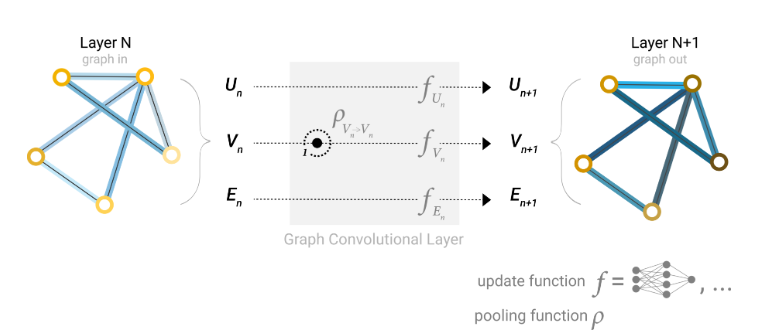


## Learning edge representations
第一步“准备”一个由边缘和连接节点的信息组成的消息，然后将消息“传递”到节点。将节点和边进行融合
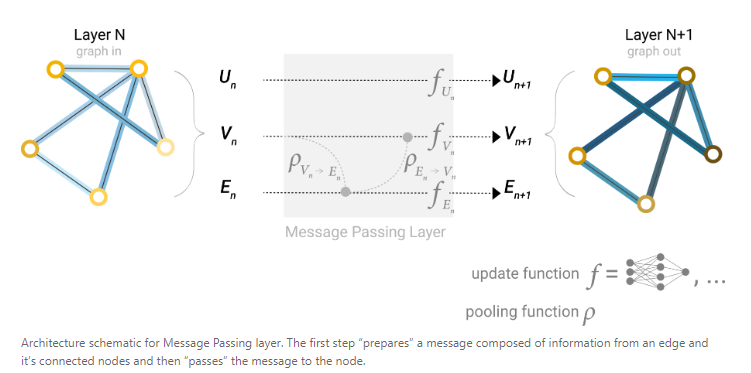
但是由于cross-representations的顺序会造成影响，出现交替更新方法
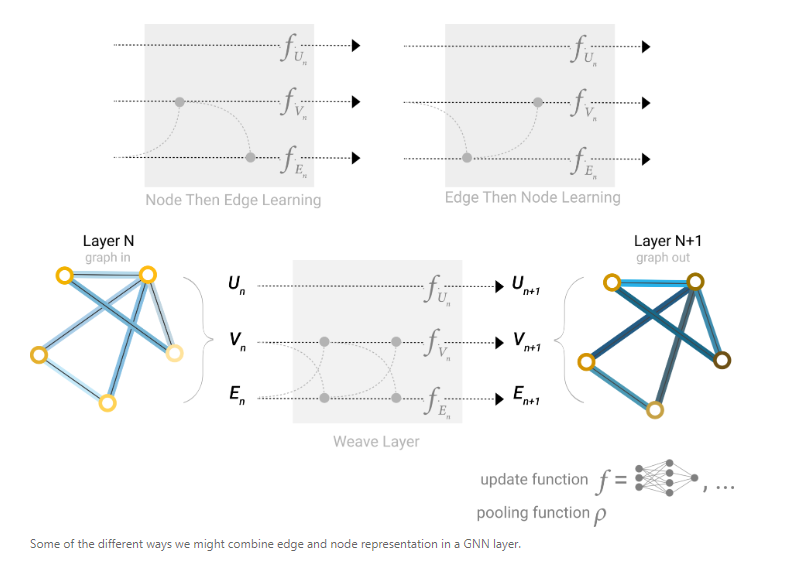

将全局信息也融合进来，为了解决远距离node之间passing缓慢的问题，使用master（global） node
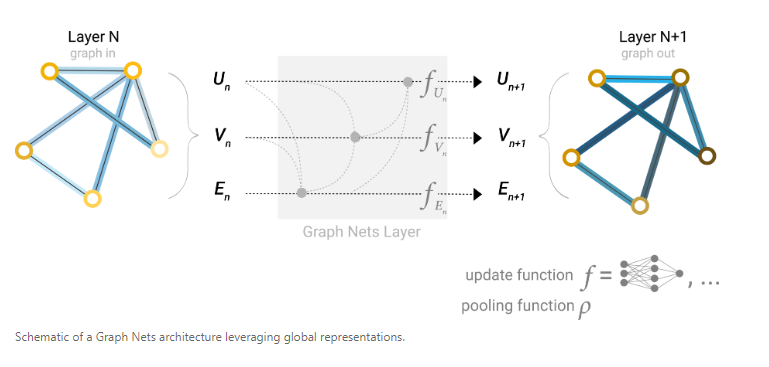

最后通过各种聚合之后，最后的模型成为了一个类似attention mechanism的结构，我们把具有汇聚结构的GNN称为GCN（graph convolutional network）
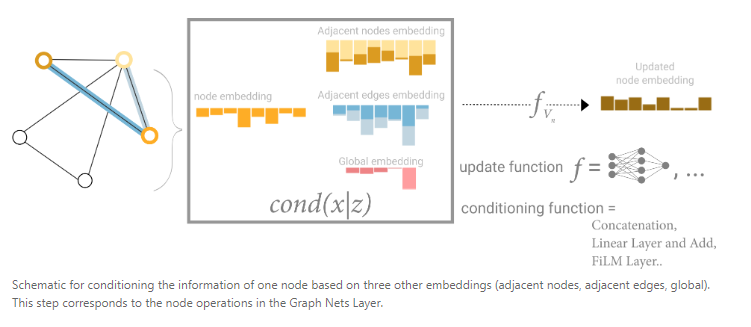

# 实验

GNN playground有一个javascript写的可视化调参的界面，很有意思，还深度探讨了层数，参数量、enbeding维度对最后结果的影响
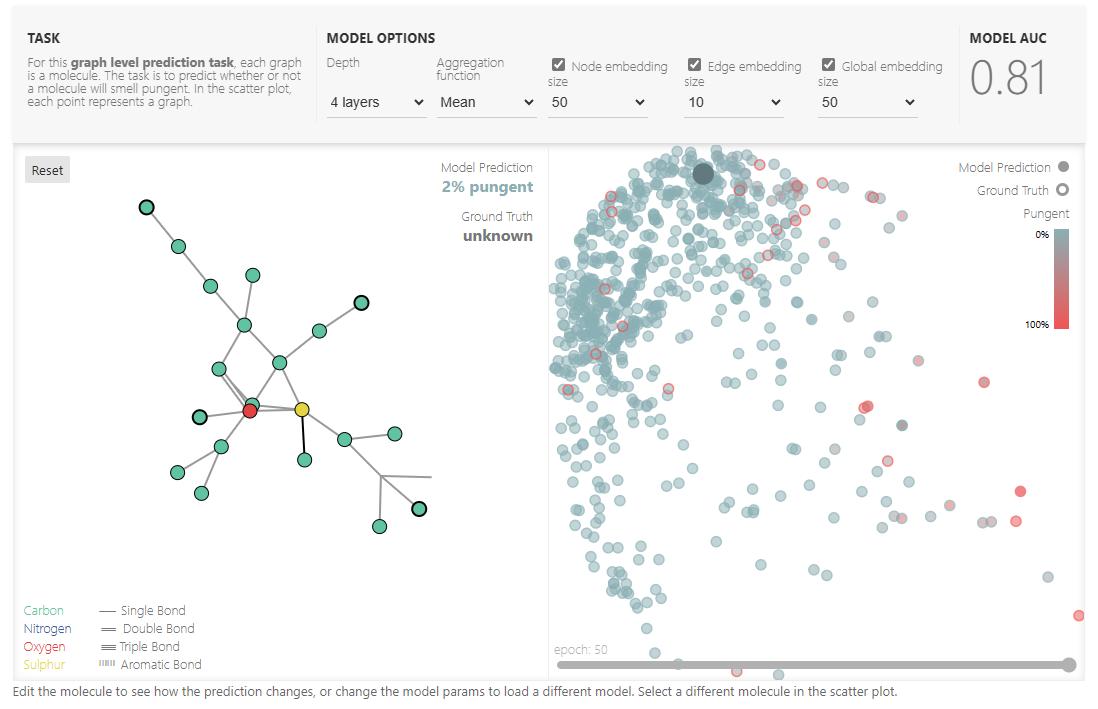

# 相关技术
## Other types of graphs (multigraphs, hypergraphs, hypernodes, hierarchical graphs)
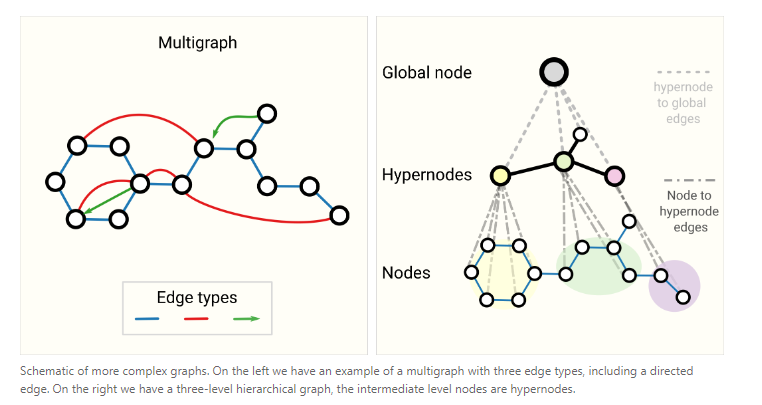
## Sampling Graphs and Batching in GNNs
Graphs如果特别大时需要做sample计算
图神经网络太大的，可以使用抽样的方式变为子图进行训练，
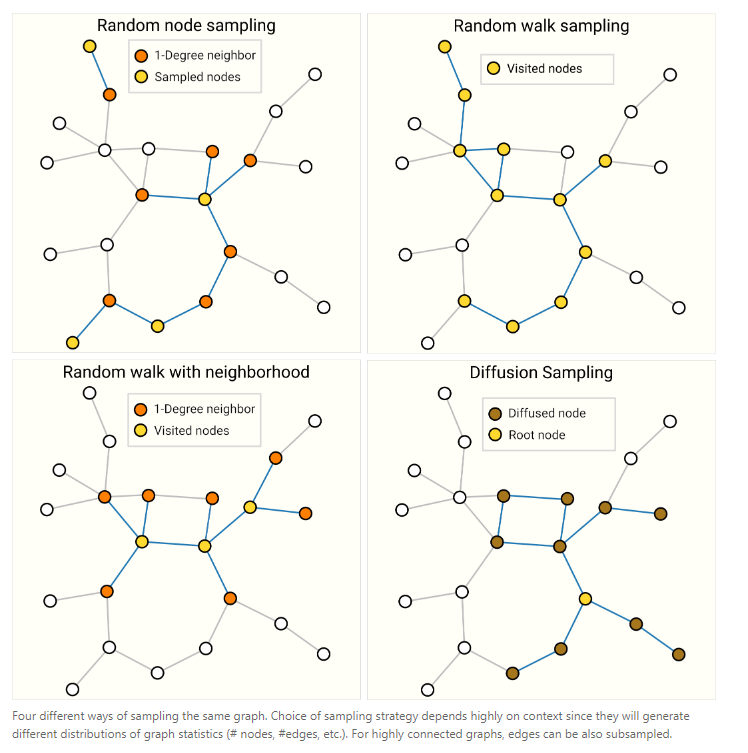

batch和sample很类似，需要额外考虑的一个事情是不同batch之间的对齐（对于nodes数量等）

## 其他
1. Comparing aggregation operations： 没有一个是better的
2. Edges and the Graph Dual
3. Graph Attention Networks：需要注意的是weight的选择，可以用self-attention之类解决